In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from collections import OrderedDict
import cv2
import numpy as np
from functools import partial

import matplotlib.pyplot as plt
import vgg16 as vgg16_model
import vgg16_deconv as vgg16deconv_model
import imagenet_label as imagenet_label

In [2]:
def save(model):
    def hook(module, input, output, key):
        if isinstance(module, nn.MaxPool2d):
            model.feature_maps[key] = output[0]
            model.pool_switch[key] = output[1]
        else:
            model.feature_maps[key] = output
    
    for i, layer in enumerate(model._modules.get('features')):
        layer.register_forward_hook(partial(hook,key=i))

In [3]:
def layerDeconv(layer_idx, conv, deconv):
    num_fmap = conv.feature_maps[layer_idx].shape[1]
    copy_fmap = conv.feature_maps[layer_idx].clone()
    
    max_list = []
    for i in range(num_fmap):
        each_fmap = copy_fmap[0,i,:,:]
        max_list.append(torch.max(each_fmap))
    #print(max_list)
    
    max_fnumber = np.argmax(np.array(max_list))
    
    
    # set all feature_map 0 except max_feature_map
    for i in range(max_fnumber):
        copy_fmap[0,i,:,:] = 0
    for i in range(max_fnumber+1,num_fmap):
        copy_fmap[0,i,:,:] = 0
    
    #print(copy_fmap[0,max_fnumber-1,:,:])
    #print(copy_fmap[0,max_fnumber,:,:])
    #print(copy_fmap[0,max_fnumber+1,:,:])
    
    
    # set max_feature_map 0 except maximum value
    max_fmap = copy_fmap[0,max_fnumber,:,:]
    max_val = torch.max(max_fmap)
    
    #print(max_fmap)
    max_fmap = torch.where(max_fmap==max_val, max_fmap, torch.zeros(max_fmap.shape))
    #print(max_fmap)
    
    copy_fmap[0,max_fnumber,:,:] = max_fmap
    
    deconv_output = deconv(copy_fmap, layer_idx, conv.pool_switch)
    #print(deconv_output.shape)
    return deconv_output

In [4]:
def visualize(deconv_output, ori_img):
    #print(deconv_output[0].shape)
    deconv_img = deconv_output[0].data.numpy()
    new_img = np.transpose(deconv_img, (1,2,0))

    new_img = cv2.normalize(new_img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    temp = new_img[0,0,0]
    leftx = 244
    lefty = 244
    rightx = 0
    righty = 0
    for i in range(224):
        for j in range(224):
            if new_img[i,j,0] > temp+0.1 or new_img[i,j,0] < temp-0.1:
                leftx = min(i,leftx)
                lefty = min(j,lefty)
                rightx = max(i,rightx)
                righty = max(j,righty)

    #print(leftx,lefty, rightx, righty)
    
    maximum = 243
    minimum = 0
    leftx = max(min(leftx-5,maximum),minimum)
    lefty = max(min(lefty-5,maximum),minimum)
    rightx = max(min(rightx+5,maximum),minimum)
    righty = max(min(righty+5,maximum),minimum)
        
    deconv = new_img[leftx:rightx, lefty:righty, :]
    original = ori_img[leftx:rightx, lefty:righty, :]

    return deconv, original

In [5]:
def convImage(img_path):
    ori_img = cv2.imread(img_path)
    ori_img = cv2.resize(ori_img, (224,224))
    b, g, r = cv2.split(ori_img)   
    ori_img = cv2.merge([r,g,b]) 

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
    img = transform(ori_img)
    img = img.unsqueeze_(0)

    output = vgg16(img)
    return ori_img, output

In [6]:
vgg16 = vgg16_model.VGG16()
save(vgg16)

vgg16deconv = vgg16deconv_model.VGG16_Deconv()
convLayer_idx = list(vgg16deconv.index_mapping.keys())

254 pug, pug-dog


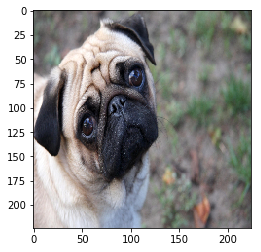

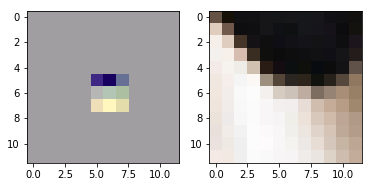

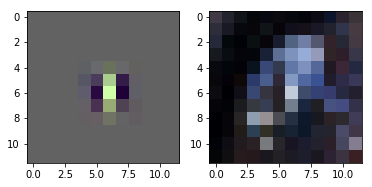

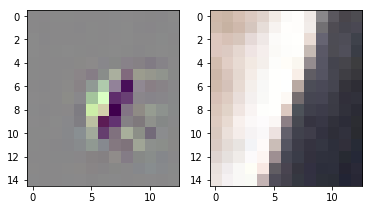

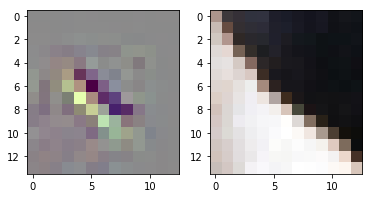

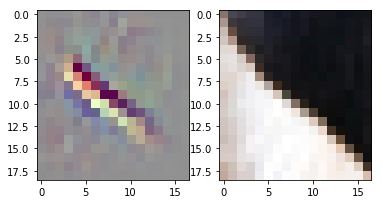

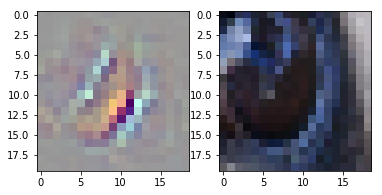

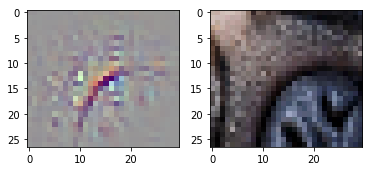

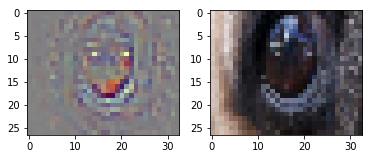

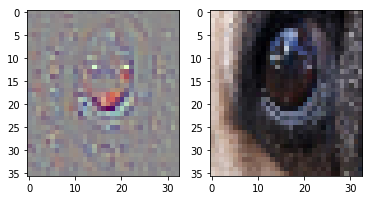

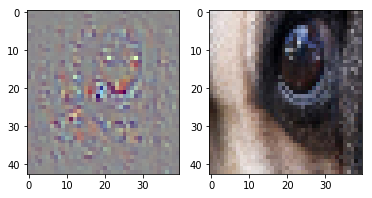

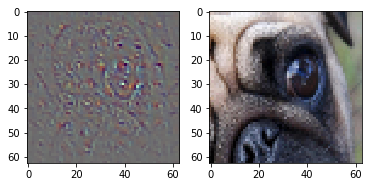

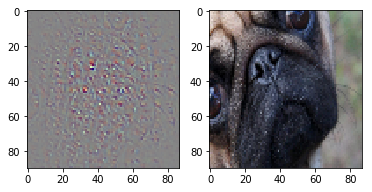

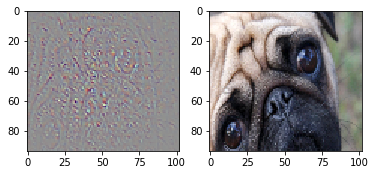

In [7]:
ori_img, output = convImage('../data/deconv/pug.jpg')
plt.figure(0)
plt.imshow(ori_img)
idx = torch.argmax(output[0]).item()
print(idx, imagenet_label.label[idx])

for i,layer in enumerate(convLayer_idx):
    plt.figure(i+1)
    deconv_output = layerDeconv(layer,vgg16,vgg16deconv)
    deconv, original = visualize(deconv_output,ori_img)
    plt.subplot(1, 2, 1)
    plt.imshow((deconv*255).astype(np.uint8))
    plt.subplot(1, 2, 2)
    plt.imshow(original)

965 burrito


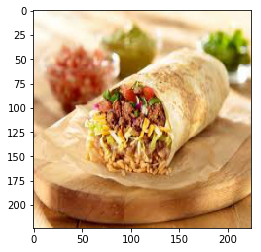

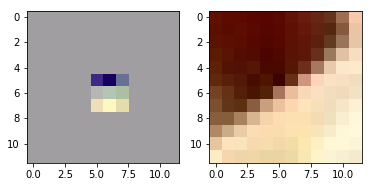

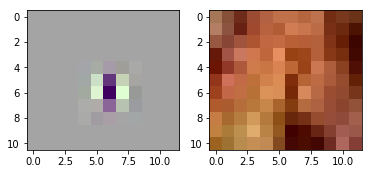

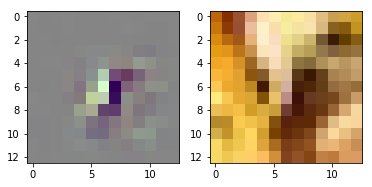

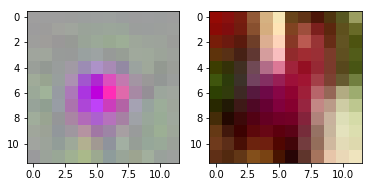

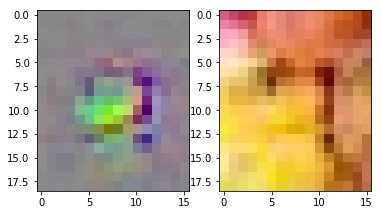

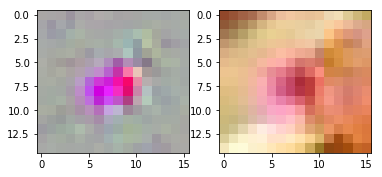

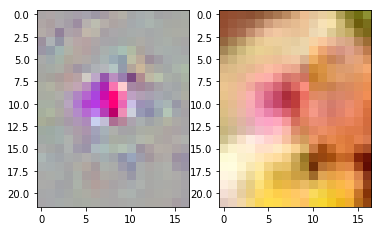

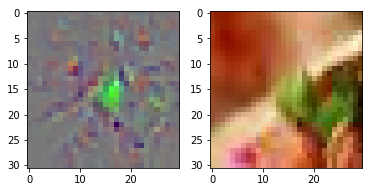

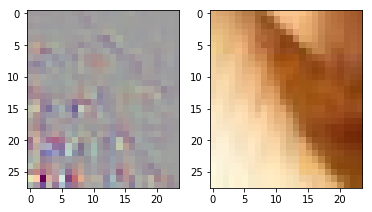

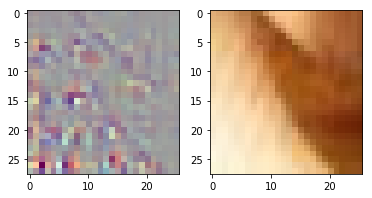

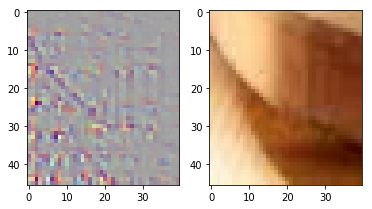

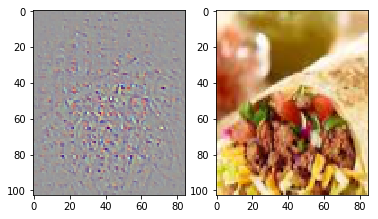

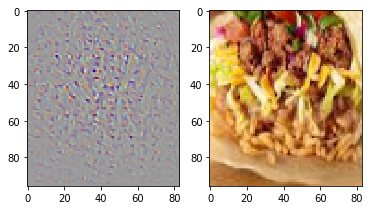

In [8]:
ori_img, output = convImage('../data/deconv/burrito.jpg')
plt.figure(0)
plt.imshow(ori_img)
idx = torch.argmax(output[0]).item()
print(idx, imagenet_label.label[idx])

for i,layer in enumerate(convLayer_idx):
    plt.figure(i+1)
    deconv_output = layerDeconv(layer,vgg16,vgg16deconv)
    deconv, original = visualize(deconv_output, ori_img)
    plt.subplot(1, 2, 1)
    plt.imshow((deconv*255).astype(np.uint8))
    plt.subplot(1, 2, 2)
    plt.imshow(original)

607 jack-o'-lantern


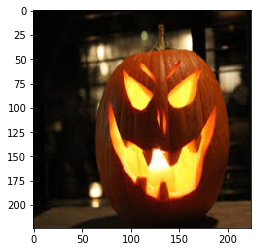

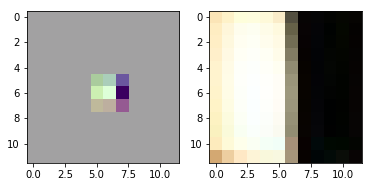

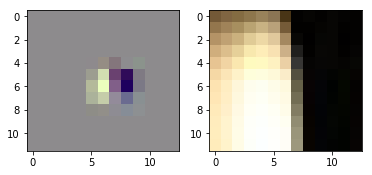

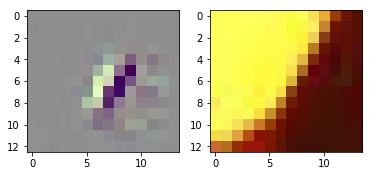

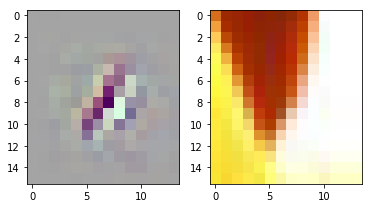

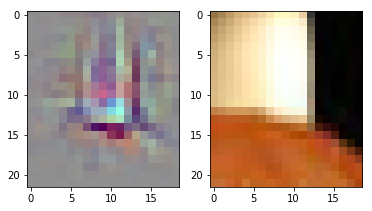

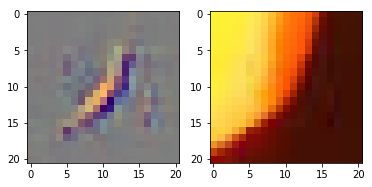

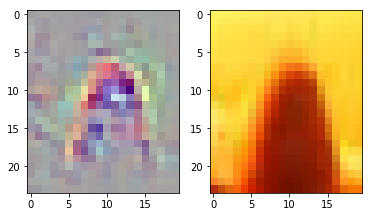

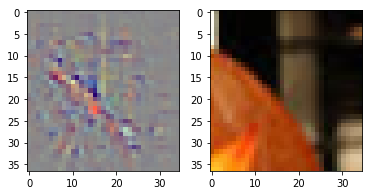

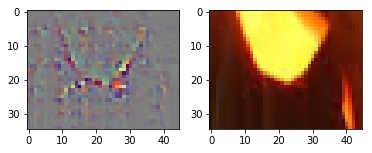

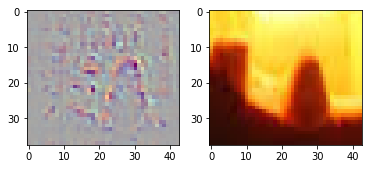

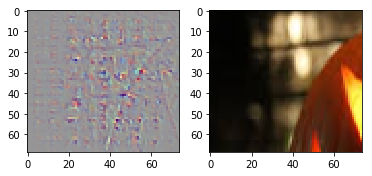

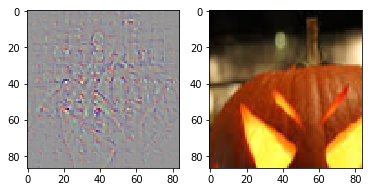

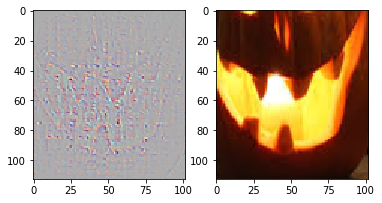

In [9]:
ori_img, output = convImage('../data/deconv/jackolantern.jpg')
plt.figure(0)
plt.imshow(ori_img)
idx = torch.argmax(output[0]).item()
print(idx, imagenet_label.label[idx])

for i,layer in enumerate(convLayer_idx):
    plt.figure(i+1)
    deconv_output = layerDeconv(layer,vgg16,vgg16deconv)
    deconv, original = visualize(deconv_output,ori_img)
    plt.subplot(1, 2, 1)
    plt.imshow((deconv*255).astype(np.uint8))
    plt.subplot(1, 2, 2)
    plt.imshow(original)